# 📈 Stock Price Prediction with LSTM (Beginner-Friendly)

Welcome! This notebook walks you through building a simple stock price predictor using:
- yfinance for data
- pandas and numpy for data prep
- sklearn for scaling
- Keras (TensorFlow) for an LSTM model

We'll cover:
1. Setup and data download
2. Quick EDA and visualizations (moving averages)
3. Preparing sequences for an LSTM
4. Train/test split
5. Build and train the model
6. Evaluate and visualize predictions
7. Save the model for use in a Streamlit app
8. Optional: Forecast the next N business days

Tip: Cells include comments so you can follow along easily.

In [65]:
# Install dependencies if needed (run once per environment)
# pip install yfinance matplotlib pandas numpy scikit-learn tensorflow keras
# If using CPU-only TensorFlow on Windows, you can use: pip install tensorflow==2.*


In [66]:
# Imports
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline


In [67]:
# Choose stock ticker and date range
stock = "GOOG"  # Try: AAPL, MSFT, TSLA
end = datetime.now()
start = datetime(end.year - 20, end.month, end.day)
print(f"Fetching {stock} data from {start.date()} to {end.date()}...")


Fetching GOOG data from 2005-09-29 to 2025-09-29...


In [68]:
# Download historical OHLCV data
try:
    google_data = yf.download(stock, start, end)
    assert not google_data.empty, "No data returned. Check the ticker symbol or dates."
except Exception as e:
    raise SystemExit(f"Failed to fetch data: {e}")

google_data.head()

[*********************100%***********************]  1 of 1 completed



Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2005-09-29,7.659181,7.686392,7.571611,7.586454,225393676
2005-09-30,7.828384,7.854111,7.725230,7.772974,367424053
2005-10-03,7.883301,7.918676,7.737598,7.758378,367785402
2005-10-04,7.693319,7.947619,7.686887,7.914719,367143003
2005-10-05,7.686145,7.789795,7.619107,7.735125,334384676


In [69]:
# Normalize columns and choose price column (handles MultiIndex vs single index)
if isinstance(google_data.columns, pd.MultiIndex):
    # If columns are like (Ticker, Field), select just the field level for our ticker
    if stock in google_data.columns.get_level_values(0):
        google_data = google_data.xs(stock, axis=1, level=0)
    else:
        # Fallback: flatten
        google_data.columns = [' '.join([str(x) for x in col if x is not None]).strip() for col in google_data.columns.values]

# Try to find the correct price column
if 'Adj Close' in google_data.columns:
    price_col = 'Adj Close'
elif 'Close' in google_data.columns:
    price_col = 'Close'
else:
    # Try to find a column that contains both 'Close' and the stock ticker
    close_cols = [col for col in google_data.columns if 'Close' in col and stock in col]
    price_col = close_cols[0] if close_cols else None

assert price_col is not None, "Could not find a suitable 'Close' or 'Adj Close' column in the data."
print(f"Using price column: {price_col}")

Using price column: Close GOOG


In [70]:
# Quick look at the first rows
google_data.head()

,Close GOOG,High GOOG,Low GOOG,Open GOOG,Volume GOOG
Date,,,,,
2005-09-29,7.659181,7.686392,7.571611,7.586454,225393676
2005-09-30,7.828384,7.854111,7.725230,7.772974,367424053
2005-10-03,7.883301,7.918676,7.737598,7.758378,367785402
2005-10-04,7.693319,7.947619,7.686887,7.914719,367143003
2005-10-05,7.686145,7.789795,7.619107,7.735125,334384676


In [71]:
# Data shape (#rows, #columns)
google_data.shape

(5031, 5)

In [72]:
# Summary statistics (min, max, mean, etc.)
google_data.describe()

,Close GOOG,High GOOG,Low GOOG,Open GOOG,Volume GOOG
count,5031.000000,5031.000000,5031.000000,5031.000000,5.031000e+03
mean,55.030657,55.596095,54.442684,55.002781,9.339821e+07
std,52.468356,53.027341,51.882734,52.422226,1.173304e+08
min,6.368385,6.663503,6.117549,6.493804,1.584340e+05
25%,14.153110,14.303389,14.017425,14.153851,2.554875e+07
50%,32.121689,32.667049,31.926525,32.241366,4.347600e+07
75%,77.413490,78.429041,76.194110,77.402065,1.158366e+08
max,255.240005,256.700012,252.067993,254.779999,1.650833e+09


In [73]:
# Basic info (dtypes and non-null counts)
google_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5031 entries, 2005-09-29 to 2025-09-29
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close GOOG   5031 non-null   float64
 1   High GOOG    5031 non-null   float64
 2   Low GOOG     5031 non-null   float64
 3   Open GOOG    5031 non-null   float64
 4   Volume GOOG  5031 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 235.8 KB


In [74]:
# Check for missing values
google_data.isna().sum()

Close GOOG     0
High GOOG      0
Low GOOG       0
Open GOOG      0
Volume GOOG    0
dtype: int64

Text(0.5, 1.0, 'Close GOOG of GOOG')

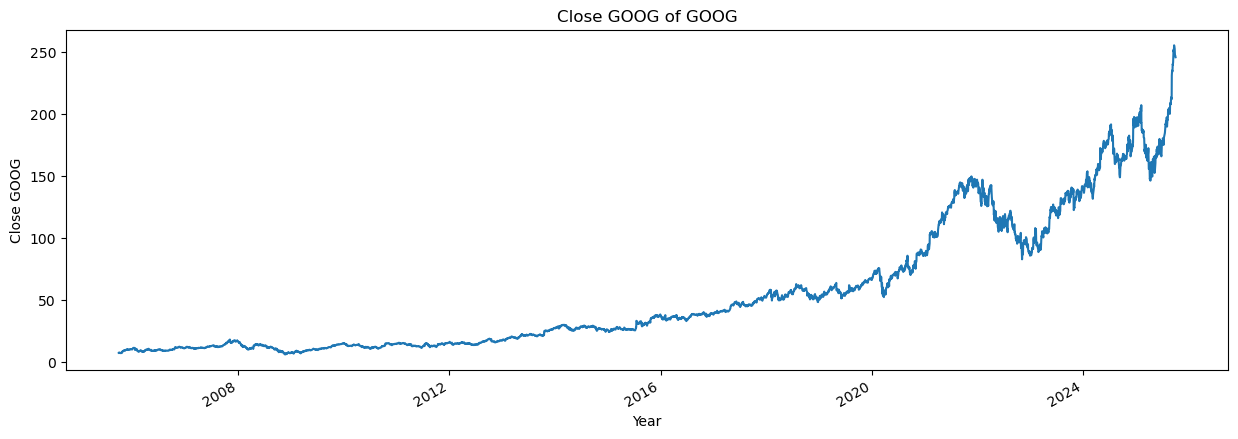

In [75]:
# Plot price column
plt.figure(figsize=(15, 5))
google_data[price_col].plot()
plt.xlabel("Year")
plt.ylabel(price_col)
plt.title(f"{price_col} of {stock}")

Text(0.5, 1.0, 'Closing price of Google (GOOG)')

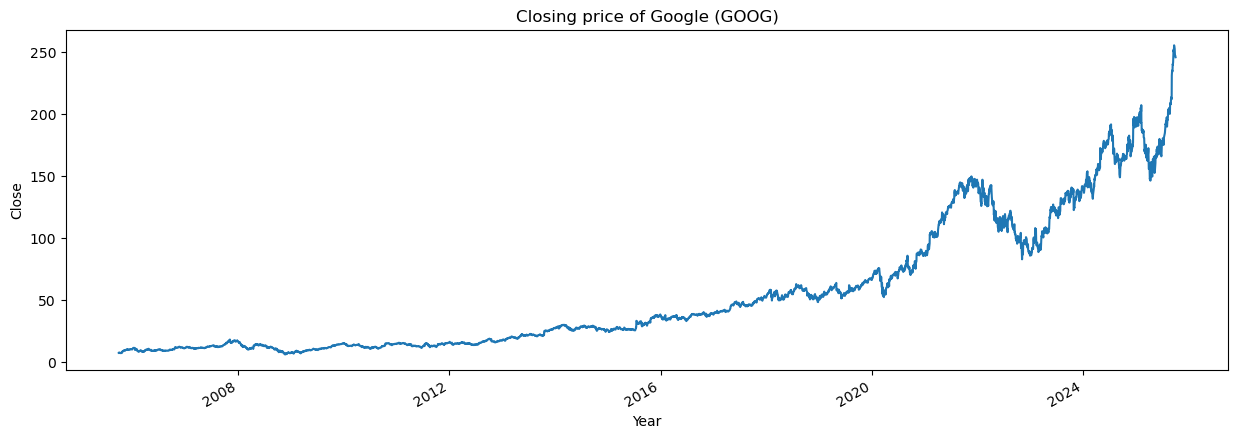

In [76]:
plt.figure(figsize=(15, 5))
google_data['Close GOOG'].plot()
plt.xlabel("Year")
plt.ylabel("Close")
plt.title("Closing price of Google (GOOG)")

In [77]:
# Helper plotting function for quick line charts
def plot_graph(figsize, values, column_name):
    plt.figure(figsize=figsize)
    values.plot()
    plt.xlabel("Year")
    plt.ylabel(column_name)
    plt.title(f"{column_name} for {stock}")

In [78]:
google_data.columns

Index(['Close GOOG', 'High GOOG', 'Low GOOG', 'Open GOOG', 'Volume GOOG'], dtype='object')

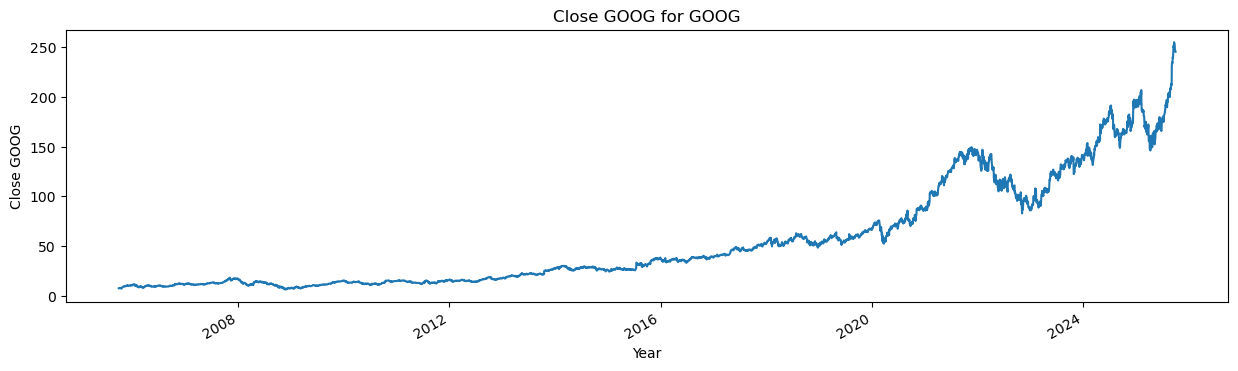

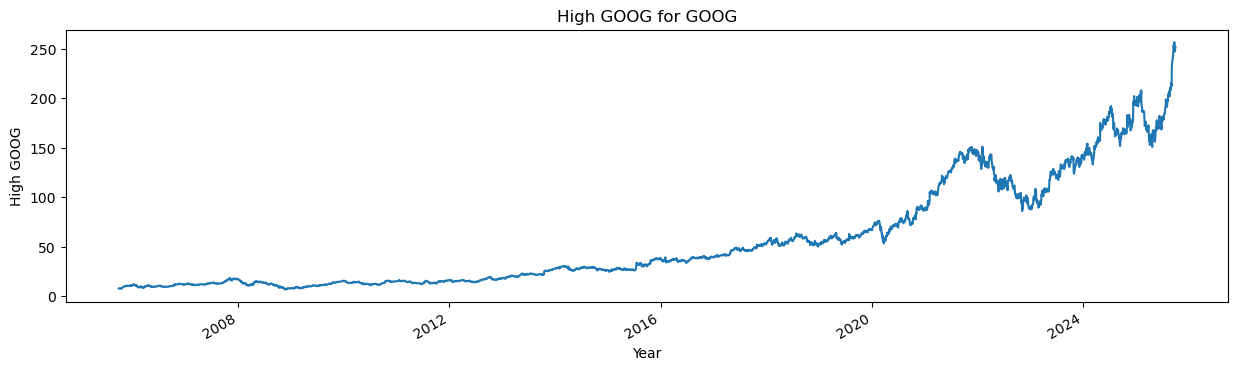

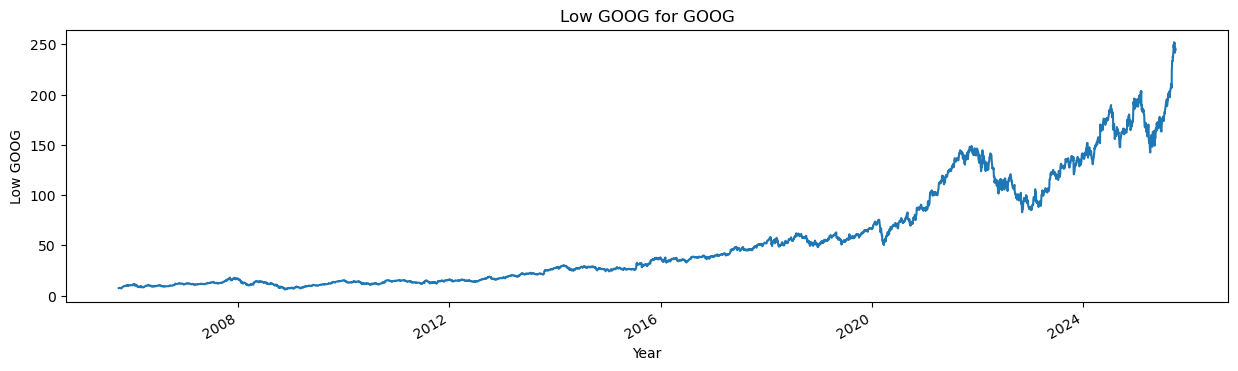

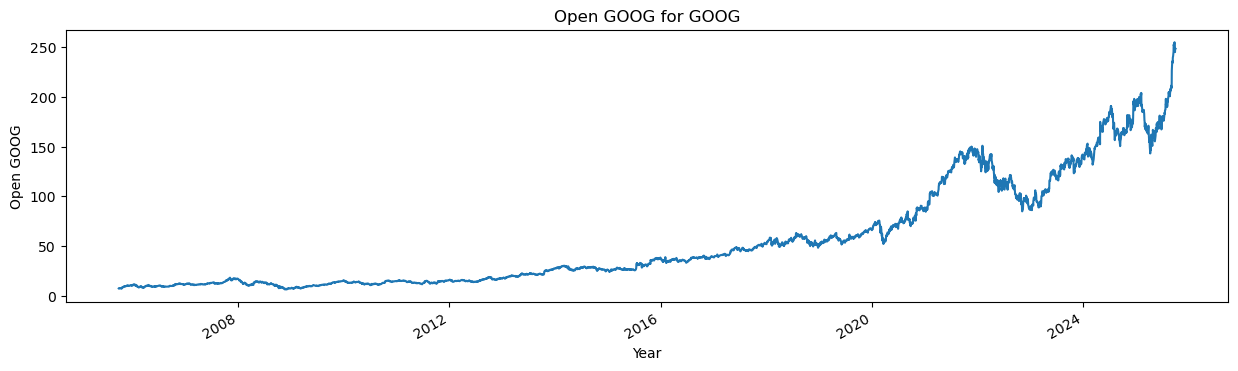

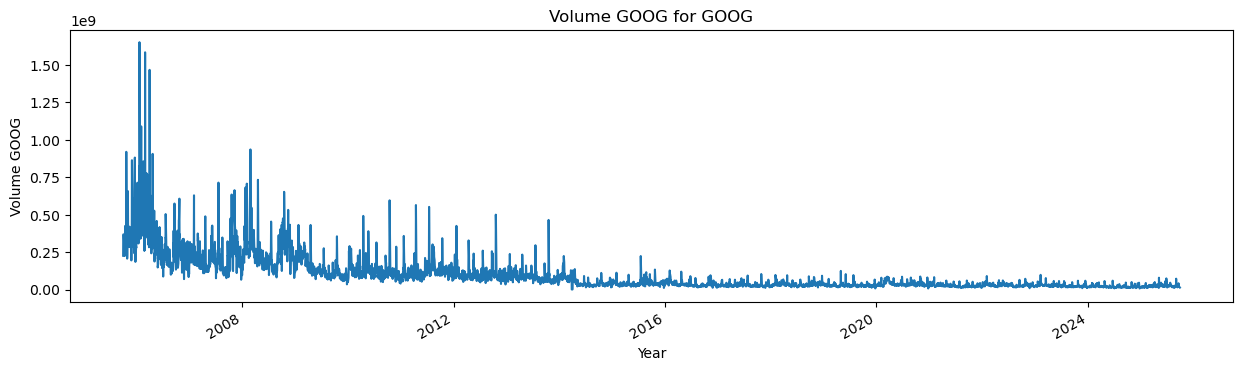

In [79]:
# Plot each column to get a feel for the data
for column in google_data.columns:
    plot_graph((15, 4), google_data[column], column)

In [80]:
# 10, 20, 30, 40, 50, 60, 70, 80, 90, 100

# MA for 5 days ==> null null null null 30 40 50 60 70 80

In [81]:
temp_data = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
print(sum(temp_data[1:6])/5)

40.0


In [82]:
import pandas as pd
data = pd.DataFrame([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
data.head()

,0
0,10
1,20
2,30
3,40
4,50


In [83]:
data['MA'] = data.rolling(5).mean()
data

,0,MA
0,10,NaN
1,20,NaN
2,30,NaN
3,40,NaN
4,50,30.0
5,60,40.0
6,70,50.0
7,80,60.0
8,90,70.0
9,100,80.0


In [84]:
for i in range(2004,2025):
    print(i,list(google_data.index.year).count(i))

2004 0
2005 65
2006 251
2007 251
2008 253
2009 252
2010 252
2011 252
2012 250
2013 252
2014 252
2015 252
2016 252
2017 251
2018 251
2019 252
2020 253
2021 252
2022 251
2023 250
2024 252


In [85]:
google_data['MA_for_250_days'] = google_data[price_col].rolling(250).mean()

In [86]:
google_data['MA_for_250_days'][0:250].tail()

Date
2006-09-20        NaN
2006-09-21        NaN
2006-09-22        NaN
2006-09-25        NaN
2006-09-26    9.61956
Name: MA_for_250_days, dtype: float64

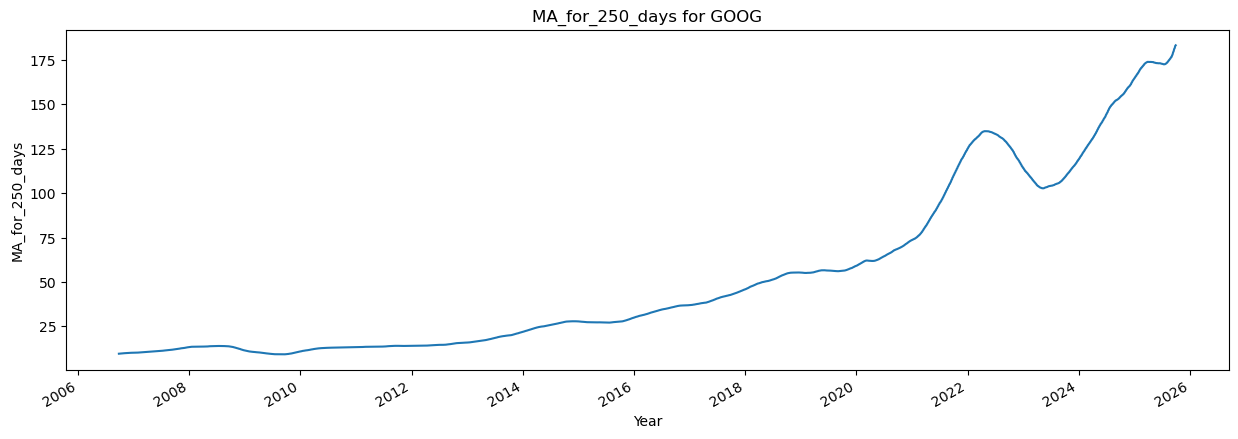

In [87]:
plot_graph((15,5), google_data['MA_for_250_days'], 'MA_for_250_days')

<Figure size 1500x500 with 0 Axes>

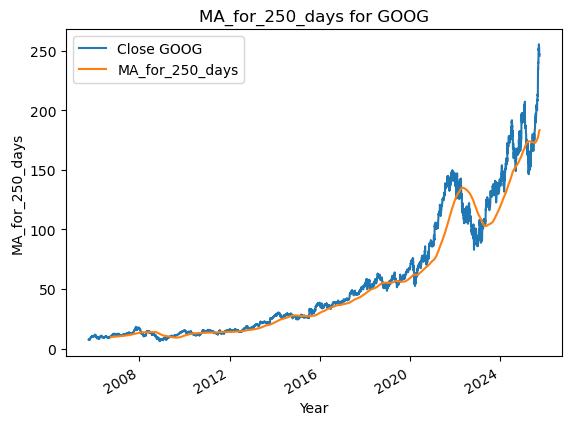

In [88]:
plot_graph((15,5), google_data[[price_col, 'MA_for_250_days']], 'MA_for_250_days')

<Figure size 1500x500 with 0 Axes>

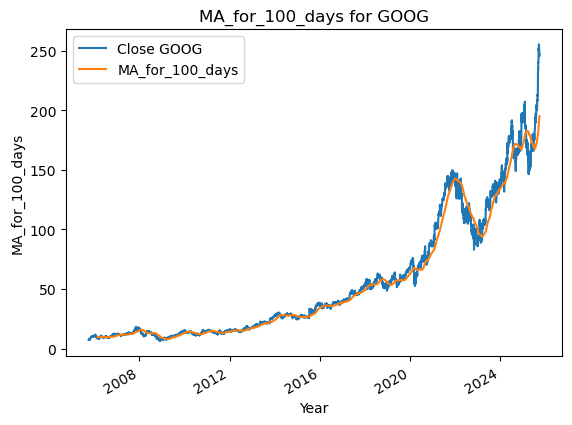

<Figure size 1500x500 with 0 Axes>

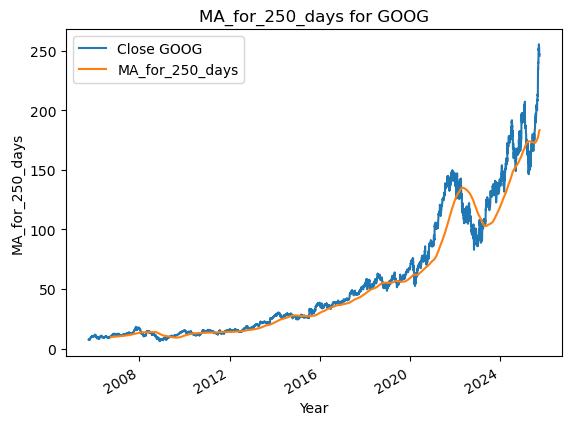

<Figure size 1500x500 with 0 Axes>

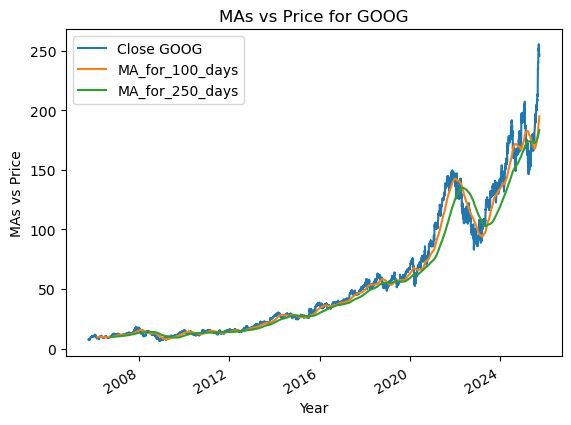

In [89]:
# Moving averages to smooth the price series
# 100-day and 250-day moving averages on selected price column
google_data['MA_for_100_days'] = google_data[price_col].rolling(100).mean()
google_data['MA_for_250_days'] = google_data[price_col].rolling(250).mean()

plot_graph((15, 5), google_data[[price_col,'MA_for_100_days']], 'MA_for_100_days')
plot_graph((15, 5), google_data[[price_col,'MA_for_250_days']], 'MA_for_250_days')
plot_graph((15, 5), google_data[[price_col,'MA_for_100_days','MA_for_250_days']], 'MAs vs Price')

In [90]:
plot_graph((15,5), google_data[['Adj Close','MA_for_100_days', 'MA_for_250_days']], 'MA')

KeyError: "['Adj Close'] not in index"

In [ ]:
# Percent change (simple daily returns) for context
google_data['pct_change'] = google_data[price_col].pct_change()
google_data[[price_col,'pct_change']].head()

,Close GOOG,pct_change
Date,,
2005-09-29,7.659181,NaN
2005-09-30,7.828385,0.022092
2005-10-03,7.883302,0.007015
2005-10-04,7.693319,-0.024099
2005-10-05,7.686145,-0.000932


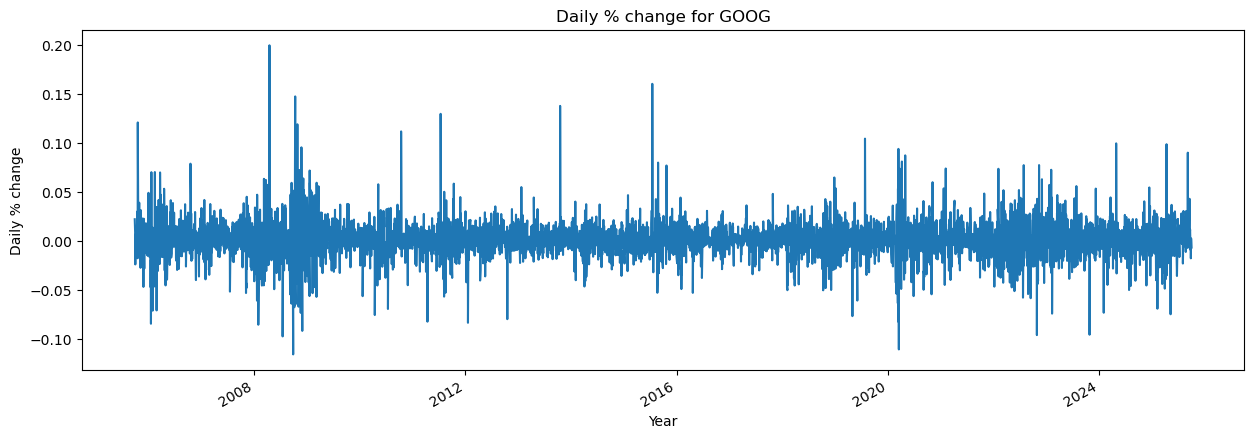

In [ ]:
plot_graph((15, 5), google_data['pct_change'], 'Daily % change')

In [ ]:
# We'll model on the chosen price column only for simplicity
Adj_close_price = google_data[[price_col]]
Adj_close_price.tail()

,Close GOOG
Date,
2025-09-23,252.339996
2025-09-24,247.830002
2025-09-25,246.570007
2025-09-26,247.179993
2025-09-29,245.479996


In [ ]:
max(Adj_close_price.values),min(Adj_close_price.values) 

(array([255.24000549]), array([6.36838531]))

In [ ]:
# Scale to 0-1: helps LSTM training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(Adj_close_price)
scaled_data[:5]

array([[0.00518659],
       [0.00586648],
       [0.00608714],
       [0.00532376],
       [0.00529494]])

In [ ]:
len(scaled_data)

5031

In [ ]:
# Create sequences: use last 100 days to predict the next day
x_data = []
y_data = []
window = 100

for i in range(window, len(scaled_data)):
    x_data.append(scaled_data[i-window:i])
    y_data.append(scaled_data[i])

x_data = np.array(x_data)
y_data = np.array(y_data)

x_data.shape, y_data.shape

((4931, 100, 1), (4931, 1))

In [ ]:
x_data[0],y_data[0]

(array([[5.39563192e-05],
        [1.35692365e-03],
        [1.53511972e-03],
        [7.94537238e-04],
        [9.79271669e-04],
        [1.29152755e-03],
        [1.00379442e-03],
        [3.26972665e-04],
        [3.85825710e-04],
        [3.92395367e-05],
        [2.45227543e-04],
        [0.00000000e+00],
        [2.56673581e-04],
        [3.74384367e-04],
        [3.76018174e-04],
        [8.69739308e-04],
        [1.22449765e-03],
        [1.87680291e-03],
        [1.96017714e-03],
        [2.28223900e-03],
        [2.85770682e-03],
        [3.16341965e-03],
        [2.91492449e-03],
        [3.00320171e-03],
        [3.40210883e-03],
        [3.24025709e-03],
        [2.98358977e-03],
        [4.38955110e-03],
        [5.07945427e-03],
        [4.83749591e-03],
        [5.32468025e-03],
        [5.73011634e-03],
        [6.27124917e-03],
        [6.06035818e-03],
        [6.34972042e-03],
        [6.16662136e-03],
        [5.76281752e-03],
        [6.11267287e-03],
        [6.6

In [ ]:

int(len(x_data)*0.7)

3365

In [ ]:
4908-100-int(len(x_data)*0.7)

1443

In [ ]:
# Train/Test split (time-aware: first 70% train, last 30% test)
splitting_len = int(len(x_data) * 0.7)
x_train = x_data[:splitting_len]
y_train = y_data[:splitting_len]

x_test = x_data[splitting_len:]
y_test = y_data[splitting_len:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3365, 100, 1)
(3365, 1)
(1443, 100, 1)
(1443, 1)


In [ ]:
# Build a simple LSTM model (beginner-friendly)
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
# Note: Increase epochs for better results (e.g., 10-20) at the cost of time
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=5, verbose=1)

Epoch 1/2

3365/3365 [==============================] - 341s 96ms/step - loss: 1.4831e-04
Epoch 2/2
3365/3365 [==============================] - 302s 90ms/step - loss: 6.2634e-05


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 128)          66560     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 25)                1625      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117619 (459.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Predict on test set
predictions = model.predict(x_test)

# Inverse scale back to original prices
inv_predictions = scaler.inverse_transform(predictions)
inv_y_test = scaler.inverse_transform(y_test)

inv_predictions[:5].flatten(), inv_y_test[:5].flatten()

46/46 [==============================] - 7s 79ms/step


In [ ]:
predictions

array([[0.346481  ],
       [0.3471811 ],
       [0.34669545],
       ...,
       [0.9589185 ],
       [0.9565912 ],
       [0.94491225]], dtype=float32)

In [ ]:
inv_predictions = scaler.inverse_transform(predictions)
inv_predictions

array([[ 55.276974],
       [ 55.383636],
       [ 55.309647],
       ...,
       [148.58127 ],
       [148.2267  ],
       [146.44743 ]], dtype=float32)

In [ ]:
inv_y_test = scaler.inverse_transform(y_test)
inv_y_test

array([[ 53.9620018 ],
       [ 53.78300095],
       [ 53.01599884],
       ...,
       [147.13999939],
       [143.94000244],
       [141.75999451]])

In [ ]:
# Evaluate with RMSE
rmse = float(np.sqrt(np.mean((inv_predictions - inv_y_test) ** 2)))
rmse

In [ ]:
rmse

2.6333577251768654

In [ ]:
# Create a DataFrame to plot true vs predicted
ploting_data = pd.DataFrame(
    {
        'original_test_data': inv_y_test.reshape(-1),
        'predictions': inv_predictions.reshape(-1)
    },
    index=google_data.index[splitting_len + 100:]
)
ploting_data.head()

,original_test_data,predictions
Date,,
2018-05-24,53.962002,55.276974
2018-05-25,53.783001,55.383636
2018-05-29,53.015999,55.309647
2018-05-30,53.389999,54.820251
2018-05-31,54.249500,54.759434


<Figure size 640x480 with 0 Axes>

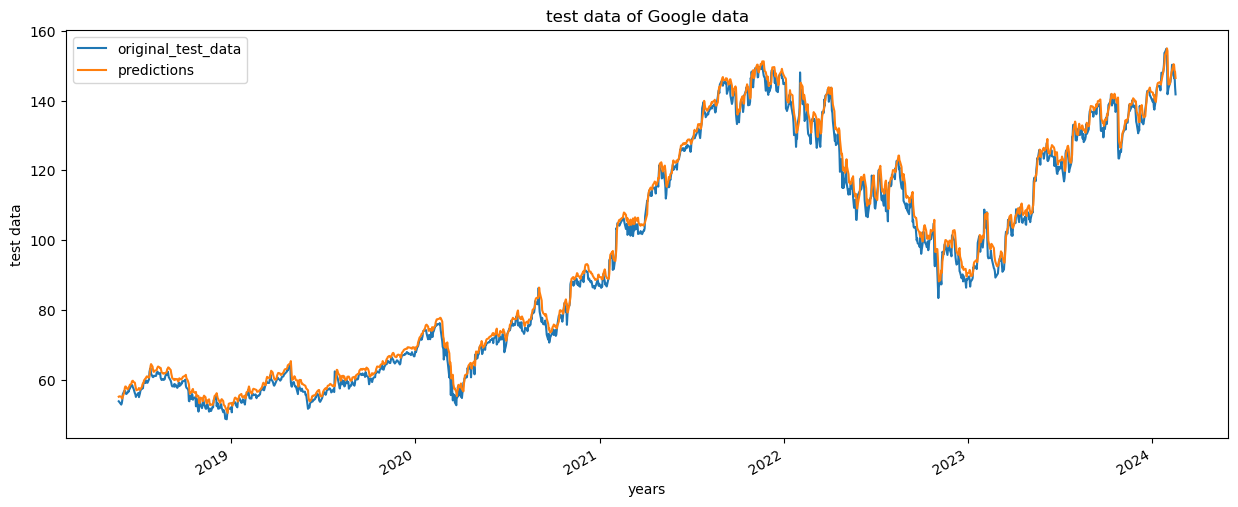

In [ ]:
# Plot test-period predictions
plot_graph((15, 6), ploting_data, 'Test predictions')

<Figure size 640x480 with 0 Axes>

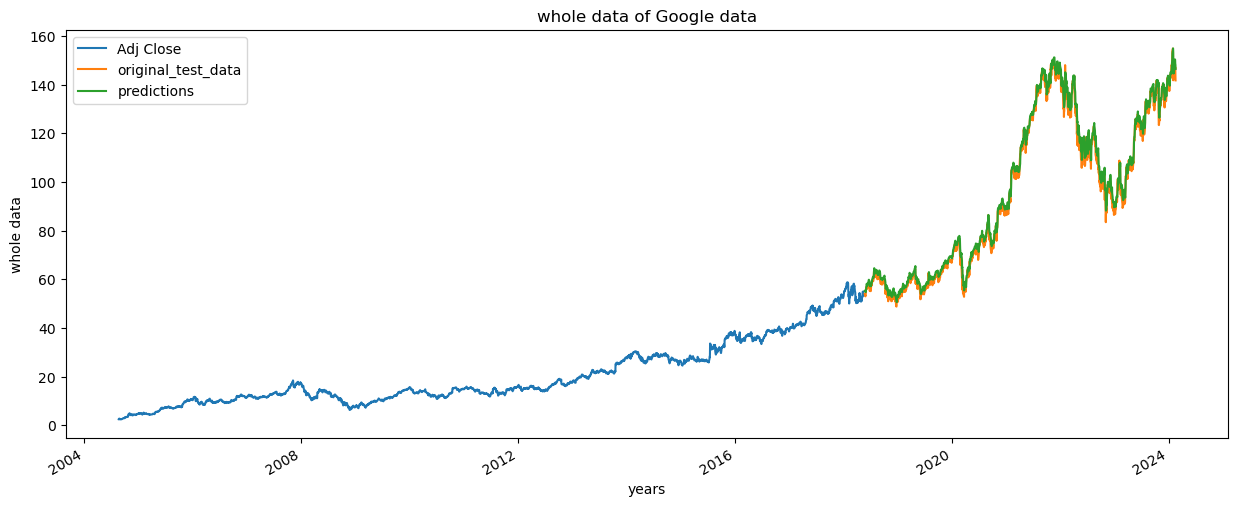

In [ ]:
# Plot on full timeline (train + test)
plot_graph((15, 6), pd.concat([Adj_close_price[:splitting_len + 100], ploting_data], axis=0), 'Full series with predictions')

In [ ]:
# Save model to disk for the web app
model.save("Latest_stock_price_model.keras")
"Model saved as Latest_stock_price_model.keras"

## 🔮 Optional: Simple Next-Day Forecast

We can generate a naive next-day forecast by feeding the last 100 scaled values into the model and predicting the next value iteratively.

Note: This is not a robust forecasting strategy, but it shows how to use the model for forward predictions.

In [ ]:
# Forecast the next N business days
N = 10
last_window = scaled_data[-100:].copy()
future_scaled = []

for _ in range(N):
    x_input = last_window.reshape(1, last_window.shape[0], 1)
    next_scaled = model.predict(x_input, verbose=0)[0, 0]
    future_scaled.append(next_scaled)
    # slide the window forward by 1
    last_window = np.vstack([last_window[1:], [[next_scaled]]])

future_prices = scaler.inverse_transform(np.array(future_scaled).reshape(-1, 1)).flatten()
future_index = pd.bdate_range(start=google_data.index[-1] + pd.Timedelta(days=1), periods=N)
forecast_df = pd.DataFrame({"forecast": future_prices}, index=future_index)

plot_graph((15, 5), pd.concat([Adj_close_price.tail(100), forecast_df], axis=0), 'Next-day forecasts')
forecast_df.head()

## 💾 Save the model

We'll save the trained model so the Streamlit web app can load it and make predictions.